In [1]:
import pandas as pd
import numpy as np
import math
import random
from keras import Input, regularizers, Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense, Embedding
from keras.utils.vis_utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/DLassignment3

hi.translit.sampled.train.tsv


In [4]:
data = pd.read_csv ("/content/drive/MyDrive/DLassignment3/hi.translit.sampled.train.tsv", sep = '\t')

In [5]:
data.rename(columns = {'अं' : 'Hindi', 'an' : 'English'}, inplace = True)


In [6]:
data

,Hindi,English,3
0,अंकगणित,ankganit,3
1,अंकल,uncle,4
2,अंकुर,ankur,4
3,अंकुरण,ankuran,3
4,अंकुरित,ankurit,3
...,...,...,...
44198,ह्वेनसांग,hiuentsang,1
44199,ह्वेनसांग,hsuantsang,1
44200,ह्वेनसांग,hyensang,1
44201,ह्वेनसांग,xuanzang,1


In [7]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
for j in range(len(data)):
  try:
    input_text=data.iloc[j,1]
    target_text=data.iloc[j,0]
    target_text = "\t" + target_text + "\n"
    if(len(input_text)>=1 and len(target_text)>=2):
      input_texts.append(input_text)
      target_texts.append(target_text)
    for char in input_text:
      if char not in input_characters:
        input_characters.add(char)
    for char in target_text:
      if char not in target_characters:
        target_characters.add(char)
  except: print("error")
input_characters.add(' ')
target_characters.add(' ')

error
error


In [8]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 44201
Number of unique input tokens: 27
Number of unique output tokens: 66
Max sequence length for inputs: 20
Max sequence length for outputs: 21


In [9]:
  tmp_x_train = []
  tmp_x_train_index = random.sample([i for i in range(0,np.array(input_texts).shape[0])],math.ceil(np.array(input_texts).shape[0]*0.7))
  tmp_x_val = []
  tmp_y_train = []
  tmp_y_val = []
  for i in tmp_x_train_index:
    tmp_x_train.append(input_texts[i])
    tmp_y_train.append(target_texts[i])
  for i in range(np.array(input_texts).shape[0]):
    if i not in tmp_x_train_index:
      tmp_x_val.append(input_texts[i])
      tmp_y_val.append(target_texts[i])
  
  lim=int(len(tmp_x_train)*0.9)
  x_train = tmp_x_train[0:lim]
  y_train = tmp_y_train[0:lim]
  x_val = tmp_x_train[lim:]
  y_val = tmp_y_train[lim:]
  x_test = tmp_x_val
  y_test = tmp_y_val

  # x_train = np.array(sample_in[:math.ceil(np.array(sample_in).shape[0]*0.7)])
  # y_train = np.array(sample_out[:math.ceil(np.array(sample_out).shape[0]*0.7)])
  # x_val = np.array(sample_in[math.ceil(np.array(sample_in).shape[0]*0.7):])
  # y_val = np.array(sample_out[math.ceil(np.array(sample_out).shape[0]*0.7):])
  # x_train = np.array(sample_in)
  # y_train = np.array(sample_out)

In [10]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [11]:
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [12]:
encoder_input_data = np.zeros(
    (len(x_train), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(x_train), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(x_train), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In [13]:
for i, (input_text, target_text) in enumerate(zip(x_train, y_train)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [14]:
encoder_input_val = np.zeros(
    (len(x_val), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_val = np.zeros(
    (len(x_val), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_val = np.zeros(
    (len(x_val), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In [15]:
for i, (input_text, target_text) in enumerate(zip(x_val, y_val)):
    for t, char in enumerate(input_text):
        encoder_input_val[i, t, input_token_index[char]] = 1.0
    encoder_input_val[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_val[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_val[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_val[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_val[i, t:, target_token_index[" "]] = 1.0

In [16]:
encoder_input_test = np.zeros(
    (len(x_test), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_test = np.zeros(
    (len(x_test), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_test = np.zeros(
    (len(x_test), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In [17]:
for i, (input_text, target_text) in enumerate(zip(x_test, y_test)):
    for t, char in enumerate(input_text):
        encoder_input_test[i, t, input_token_index[char]] = 1.0
    encoder_input_test[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_test[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_test[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_test[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_test[i, t:, target_token_index[" "]] = 1.0

In [18]:
encoder_input_data.shape

(27846, 20, 27)

In [19]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_inputs_1 = encoder_inputs

encoder_inputs_1, state_h_1, state_c_1 = (LSTM(256, return_state=True))(encoder_inputs_1)
encoder_state = [state_h_1, state_c_1]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_inputs_1, _, _ = (LSTM(256, return_sequences=True,return_state=True))(decoder_inputs, initial_state=encoder_state)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
decoder_outputs = decoder_dense(decoder_inputs_1)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

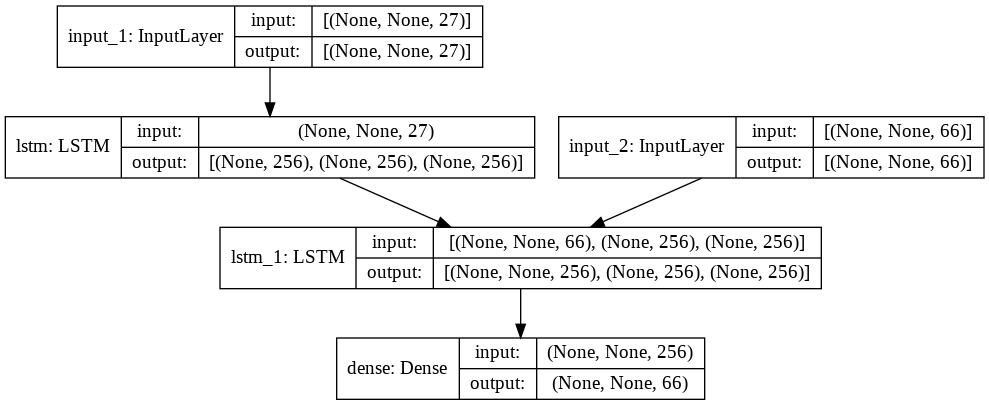

In [20]:
plot_model(model, to_file='model.png', show_shapes=True)

In [21]:
# define encoder inference model
encoder_model = Model(encoder_inputs, encoder_state)

In [22]:
# define decoder inference model
# Below tensors will hold the states of the previous time step
decoder_states_inputs_h = Input(shape=(256,))
decoder_states_inputs_c = Input(shape=(256,))
decoder_states_inputs = [decoder_states_inputs_h,decoder_states_inputs_c]

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_states = []
decoder_outputs, state_h, state_c = (LSTM(256, return_sequences=True, return_state=True))(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states.append(state_h)
decoder_states.append(state_c)
decoder_outputs_2 = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs_2] + decoder_states)

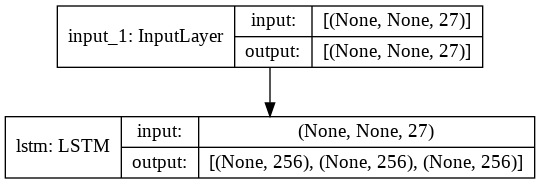

In [23]:
plot_model(encoder_model, to_file='encoder_model.png', show_shapes=True)

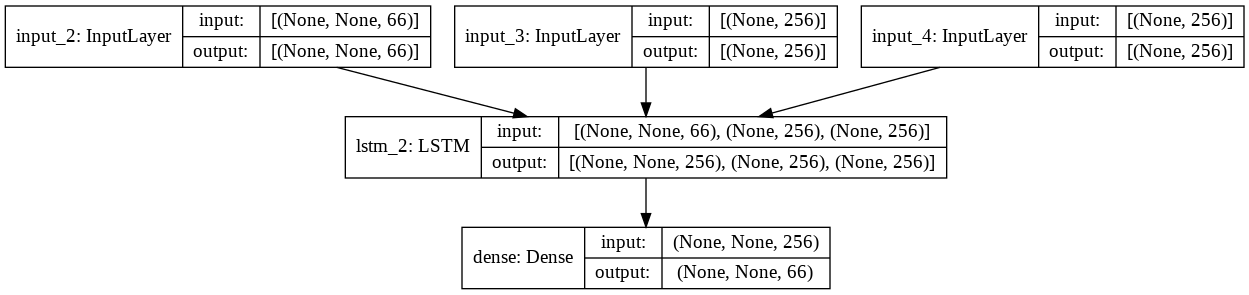

In [24]:
plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True)

In [25]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit([encoder_input_data, decoder_input_data],decoder_target_data, epochs=15,validation_data=([encoder_input_val, decoder_input_val],decoder_target_val), batch_size=32)

Epoch 1/15
871/871 [==============================] - 29s 9ms/step - loss: 1.4799 - accuracy: 0.6949 - val_loss: 1.0351 - val_accuracy: 0.7454
Epoch 2/15
871/871 [==============================] - 7s 8ms/step - loss: 0.9895 - accuracy: 0.7567 - val_loss: 0.9096 - val_accuracy: 0.7753
Epoch 3/15
871/871 [==============================] - 7s 8ms/step - loss: 0.8957 - accuracy: 0.7813 - val_loss: 0.8459 - val_accuracy: 0.7973
Epoch 4/15
871/871 [==============================] - 7s 8ms/step - loss: 0.8366 - accuracy: 0.7991 - val_loss: 0.7960 - val_accuracy: 0.8114
Epoch 5/15
871/871 [==============================] - 7s 8ms/step - loss: 0.7826 - accuracy: 0.8153 - val_loss: 0.7492 - val_accuracy: 0.8263
Epoch 6/15
871/871 [==============================] - 7s 8ms/step - loss: 0.7362 - accuracy: 0.8309 - val_loss: 0.7084 - val_accuracy: 0.8375
Epoch 7/15
871/871 [==============================] - 7s 8ms/step - loss: 0.6864 - accuracy: 0.8479 - val_loss: 0.6890 - val_accuracy: 0.8432
Epoch